In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import string

# ---------- Publication style ----------
DPI = 300
TARGET_WIDTH_MM = 180
TARGET_WIDTH_IN = TARGET_WIDTH_MM / 25.4

CORE_MAP = {
    "20892": "Station 27",
    "19908": "Station 15",
    "19119": "Station 5",
}

# Panel definitions: (elements, x-axis label)
PANELS = [
    (["Fe", "Ti", "Ca", "K", "Al", "Si"], "Concentration (wt%)"),
    (["C", "N", "S"],                      "Concentration (wt%)"),
]

# Distinct colors per element (shared across all panels)
ELEMENT_COLORS = {
    "Fe": "#d62728", "Ti": "#9467bd", "Ca": "#2ca02c",
    "K":  "#ff7f0e", "Al": "#1f77b4", "Si": "#8c564b",
    "C":  "#1f77b4", "N":  "#ff7f0e",
    "S":  "#2ca02c",
}
ELEMENT_MARKERS = {
    "Fe": "o", "Ti": "D", "Ca": "s", "K": "^", "Al": "v", "Si": "p",
    "C": "o", "N": "s",
    "S": "D",
}

In [20]:
# ---------- Load all XRF and CHNS data ----------
base = Path("elemental_composition")
frames = []

# XRF files
for f in sorted(base.glob("xrf/*_xrf.csv")):
    core_id = f.stem.split("_")[0]
    station = CORE_MAP.get(core_id, f"Core {core_id}")
    xrf = pd.read_csv(f)
    xrf.columns = xrf.columns.str.strip()
    xrf["Depth"] = xrf["Depth"].str.strip()
    xrf["Component"] = xrf["Component"].str.strip()
    xrf["depth_cm"] = xrf["Depth"].str.extract(r"(\d+)").astype(int)
    xrf_long = xrf[["depth_cm", "Component", "Result", "Unit"]].copy()
    xrf_long.columns = ["depth_cm", "element", "value", "unit"]
    xrf_long["core_id"] = core_id
    xrf_long["station"] = station
    xrf_long["source"] = "XRF"
    frames.append(xrf_long)

# CHNS files
for f in sorted(base.glob("chns/*_chns.csv")):
    core_id = f.stem.split("_")[0]
    station = CORE_MAP.get(core_id, f"Core {core_id}")
    chns = pd.read_csv(f)
    chns.columns = chns.columns.str.strip()
    chns["depth_cm"] = chns["sample name"].str.extract(r"(\d+)cm").astype(int)

    # Melt element columns (C%, N%, etc.)
    elem_cols = [c for c in chns.columns if c.endswith("%")]
    melted = chns.melt(
        id_vars=["depth_cm"], value_vars=elem_cols,
        var_name="element", value_name="value",
    )
    melted["element"] = melted["element"].str.replace("%", "")
    melted["unit"] = "wt%"
    melted["source"] = "CHNS"
    melted["core_id"] = core_id
    melted["station"] = station
    frames.append(melted)

    # C/N ratio
    ratio = chns.melt(
        id_vars=["depth_cm"], value_vars=["C/N ratio"],
        var_name="element", value_name="value",
    )
    ratio["element"] = "C/N"
    ratio["unit"] = "molar"
    ratio["source"] = "CHNS"
    ratio["core_id"] = core_id
    ratio["station"] = station
    frames.append(ratio)

df = pd.concat(frames, ignore_index=True)
cores = sorted(df["core_id"].unique(), key=lambda x: CORE_MAP.get(x, x))
print(f"Cores loaded: {cores}")
print(f"Elements available: {sorted(df['element'].unique())}")

Cores loaded: ['20892']
Elements available: ['Ag', 'Al', 'Br', 'C', 'C/N', 'Ca', 'Cl', 'Cu', 'Fe', 'H', 'K', 'Mg', 'Mn', 'N', 'Na', 'P', 'Rb', 'Rh', 'S', 'Si', 'Sr', 'Ti', 'Zn', 'Zr']


Saved: figure_elemental_depth_profiles.png
Saved: figure_elemental_depth_profiles.pdf


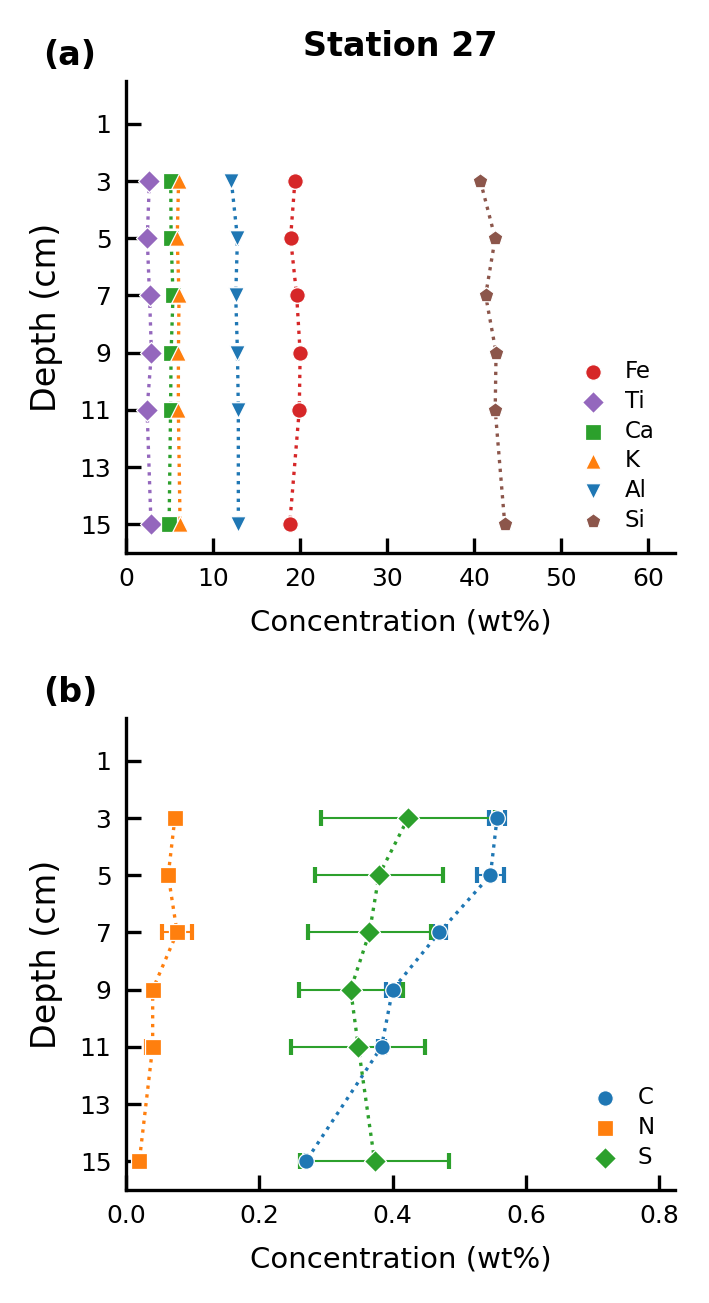

In [21]:
# ---------- Figure: 2-row × N-station grid ----------
n_rows = len(PANELS)
n_cols = len(cores)
panel_labels = list(string.ascii_lowercase)
panel_idx = 0

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(TARGET_WIDTH_IN * n_cols / 3, n_rows * 2.4),
    sharey=True, dpi=DPI, squeeze=False,
)

# Station title(s) across the top
for col_idx, core_id in enumerate(cores):
    station = CORE_MAP.get(core_id, f"Core {core_id}")
    axes[0, col_idx].set_title(station, fontsize=8, fontweight="bold")

for col_idx, core_id in enumerate(cores):
    station = CORE_MAP.get(core_id, f"Core {core_id}")
    core_df = df[df["core_id"] == core_id]

    for row_idx, (elements, xlabel) in enumerate(PANELS):
        ax = axes[row_idx, col_idx]

        xmax = 0
        for elem in elements:
            subset = core_df[core_df["element"] == elem]
            if subset.empty:
                continue

            stats = (subset.groupby("depth_cm")["value"]
                     .agg(["mean", "std"]).reset_index()
                     .sort_values("depth_cm"))

            # Track max data extent (mean + std)
            upper = (stats["mean"] + stats["std"].fillna(0)).max()
            if upper > xmax:
                xmax = upper

            # Plot error bars without label, then scatter with label
            ax.errorbar(
                stats["mean"], stats["depth_cm"],
                xerr=stats["std"], fmt="none",
                color=ELEMENT_COLORS.get(elem, "#333"),
                capsize=2, elinewidth=0.5,
            )
            ax.plot(
                stats["mean"], stats["depth_cm"],
                linestyle=":", color=ELEMENT_COLORS.get(elem, "#333"),
                linewidth=0.8,
            )
            ax.scatter(
                stats["mean"], stats["depth_cm"],
                marker=ELEMENT_MARKERS.get(elem, "o"),
                color=ELEMENT_COLORS.get(elem, "#333"),
                s=14, zorder=3, label=elem,
                edgecolors="white", linewidths=0.3,
            )

        # Pad x-axis to make room for legend
        ax.set_xlim(0, xmax * 1.45 if xmax > 0 else 1)

        ax.tick_params(labelsize=6, direction="in")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_xlabel(xlabel, fontsize=7)

        # Panel label
        ax.text(-0.15, 1.02, f"({panel_labels[panel_idx]})",
                transform=ax.transAxes, fontsize=8, fontweight="bold",
                va="bottom", ha="left")
        panel_idx += 1

        # Legend inside each panel
        if len(elements) > 1:
            ax.legend(fontsize=5.5, loc="lower right", frameon=False,
                      handlelength=1.2, labelspacing=0.3)

        # Y-axis label only on leftmost column
        if col_idx == 0:
            ax.set_ylabel("Depth (cm)", fontsize=8)

# Invert y-axis: set ylim with larger value first (0 at top, max at bottom)
ymax = df["depth_cm"].max()
axes[0, 0].set_ylim(ymax + 1, -0.5)
axes[0, 0].set_yticks([1, 3, 5, 7, 9, 11, 13, 15])

fig.subplots_adjust(hspace=0.35, wspace=0.08)

# Save
for ext in ("png", "pdf"):
    outpath = Path(f"figure_elemental_depth_profiles.{ext}")
    fig.savefig(outpath, dpi=DPI, bbox_inches="tight",
                facecolor="white", pad_inches=0.05)
    print(f"Saved: {outpath}")

plt.show()